# <a>Project 2 - Regression Using Scikit Learn</a>

## Let's Data - Data Science Journey

*By Reginaldo Jr - <a>reginaldojr@yahoo.com</a>*

### Imports and Configurations

In [38]:
import pandas as pd
import seaborn as sns
import warnings

from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RANSACRegressor, HuberRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.cross_decomposition import PLSRegression

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from xgboost import XGBRFRegressor
from statsmodels import api as sm

from sklearn.metrics import r2_score,mean_squared_error

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.2f" % x)

warnings.filterwarnings("ignore")

sns.set_style("darkgrid")

### Data

In [39]:
df = pd.read_csv("insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.92
1,18,male,33.77,1,no,southeast,1725.55
2,28,male,33.00,3,no,southeast,4449.46
3,33,male,22.70,0,no,northwest,21984.47
4,32,male,28.88,0,no,northwest,3866.86


In [40]:
df.shape

(1338, 7)

In [41]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [104]:
df.isnull().sum()

age                 0
bmi                 0
children            0
charges             0
sex_male            0
smoker_yes          0
region_northwest    0
region_southeast    0
region_southwest    0
dtype: int64

### EDA

In [43]:
df.describe()

,age,bmi,children,charges
count,1338.00,1338.00,1338.00,1338.00
mean,39.21,30.66,1.09,13270.42
std,14.05,6.10,1.21,12110.01
min,18.00,15.96,0.00,1121.87
25%,27.00,26.30,0.00,4740.29
50%,39.00,30.40,1.00,9382.03
75%,51.00,34.69,2.00,16639.91
max,64.00,53.13,5.00,63770.43


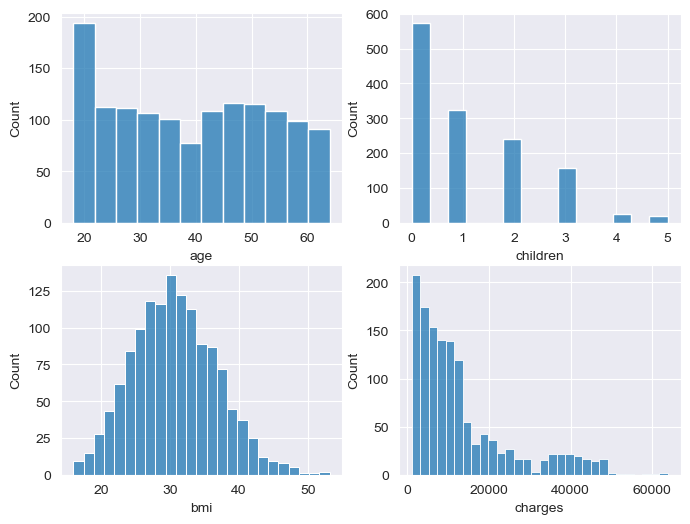

In [44]:
fig, graf = plt.subplots(2,2, figsize=(8,6))

for i,col in enumerate(df.describe().columns):
    sns.histplot(data=df, x=col, ax=graf[i%2][i//2])

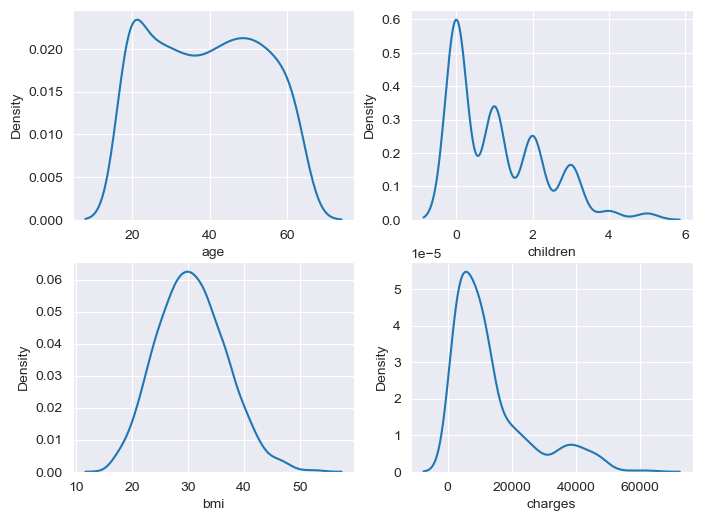

In [45]:
fig, graf = plt.subplots(2,2, figsize=(8,6))

for i,col in enumerate(df.describe().columns):
    sns.kdeplot(data=df, x=col, ax=graf[i%2][i//2])

<Axes: xlabel='children', ylabel='count'>

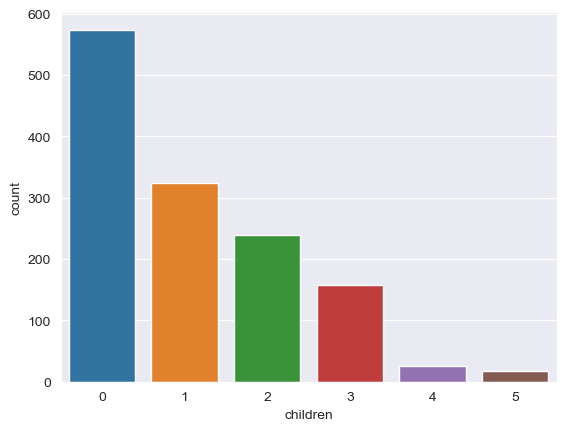

In [46]:
plt.tight_layout()
sns.countplot(data=df, x="children")

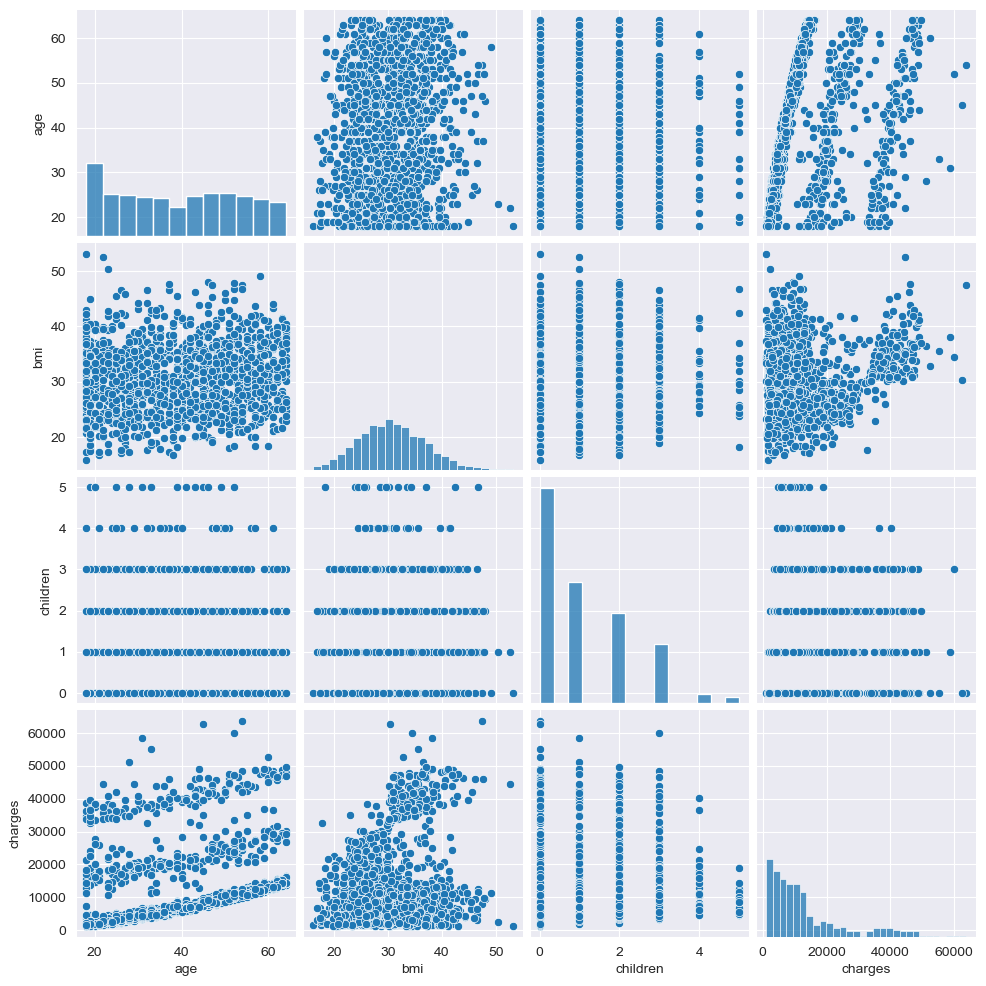

In [47]:
sns.pairplot(data=df)

### Coding of Categorical Variables

In [48]:
categorical_cols = [col for col in df.columns if df[col].dtype=="O"]
categorical_cols

['sex', 'smoker', 'region']

In [49]:
encoder = OneHotEncoder(drop='first')
ohe = encoder.fit(df[categorical_cols])
display(ohe.feature_names_in_)
display(ohe.categories_)

array(['sex', 'smoker', 'region'], dtype=object)

[array(['female', 'male'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object)]

In [50]:
ohe.get_feature_names_out()

array(['sex_male', 'smoker_yes', 'region_northwest', 'region_southeast',
       'region_southwest'], dtype=object)

In [51]:
ohe.transform(df[categorical_cols]).toarray()

array([[0., 1., 0., 0., 1.],
       [1., 0., 0., 1., 0.],
       [1., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 1., 0., 0.]])

In [52]:
pd.DataFrame(ohe.transform(df[categorical_cols]).toarray(), columns=ohe.get_feature_names_out(), index=df.index, dtype=int).head()

,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,0,1,0,0,1
1,1,0,0,1,0
2,1,0,0,1,0
3,1,0,1,0,0
4,1,0,1,0,0


In [53]:
df = pd.concat([df, pd.DataFrame(ohe.transform(df[categorical_cols]).toarray(), columns=ohe.get_feature_names_out(), index=df.index)], axis=1)
df = df.drop(categorical_cols, axis=1)
df.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.90,0,16884.92,0.00,1.00,0.00,0.00,1.00
1,18,33.77,1,1725.55,1.00,0.00,0.00,1.00,0.00
2,28,33.00,3,4449.46,1.00,0.00,0.00,1.00,0.00
3,33,22.70,0,21984.47,1.00,0.00,1.00,0.00,0.00
4,32,28.88,0,3866.86,1.00,0.00,1.00,0.00,0.00


### Correlation between variables

<Axes: >

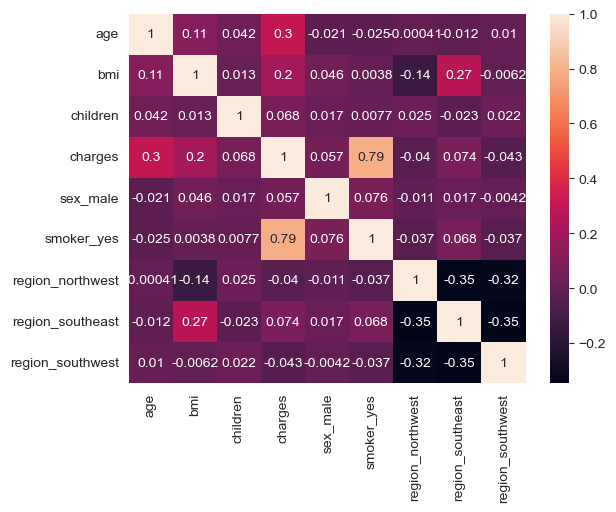

In [54]:
sns.heatmap(data=df.corr(), annot=True)

### Missing Data

In [55]:
df.isnull().sum()

age                 0
bmi                 0
children            0
charges             0
sex_male            0
smoker_yes          0
region_northwest    0
region_southeast    0
region_southwest    0
dtype: int64

### Variables Separation

In [56]:
X= df.drop(["charges"], axis=1)
X.head()

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.90,0,0.00,1.00,0.00,0.00,1.00
1,18,33.77,1,1.00,0.00,0.00,1.00,0.00
2,28,33.00,3,1.00,0.00,0.00,1.00,0.00
3,33,22.70,0,1.00,0.00,1.00,0.00,0.00
4,32,28.88,0,1.00,0.00,1.00,0.00,0.00


In [57]:
y= df[["charges"]]
y.head()

,charges
0,16884.92
1,1725.55
2,4449.46
3,21984.47
4,3866.86


### Base separation

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1070, 8), (268, 8), (1070, 1), (268, 1))

### Machine Learning with Cross Validation

In [59]:
kfold = KFold(random_state=42,n_splits=10,shuffle=True)
scoring = "neg_root_mean_squared_error"

def GetBestModel(X_, y_):
    scalers = [("MinMaxScaler",MinMaxScaler()),("StandardScaler",StandardScaler()),("Normalizer",Normalizer())]

    models = []
    models.append(("LinearRegression",LinearRegression()))
    models.append(("Ridge", Ridge(random_state=42)))
    models.append(("Lasso", Lasso(random_state=42)))
    models.append(("ElasticNet", ElasticNet(random_state=42)))
    models.append(("RANSACRegressor", RANSACRegressor(random_state=42)))
    models.append(("HuberRegressor", HuberRegressor()))
    
    models.append(("ExtraTreeRegressor",ExtraTreeRegressor(random_state=42)))
    models.append(("DecisionTreeRegressor", DecisionTreeRegressor(random_state=42)))
    models.append(("KNeighborsRegressor",KNeighborsRegressor()))
    models.append(("SVR",SVR()))
    models.append(("GaussianProcessRegressor", GaussianProcessRegressor(random_state=42)))
    models.append(("MLPRegressor", MLPRegressor(random_state=42)))
    models.append(("PLSRegression", PLSRegression()))

    results={}
    for name_scaler, scaler in scalers:
        for name_model, model in models:
            estimator = make_pipeline(scaler, model)
            result = cross_val_score(estimator=estimator, X=X_, y=y_, cv=kfold, scoring=scoring)
            results[name_scaler,name_model] = result

    df_results = pd.DataFrame(results)
    for col in df_results.columns:
        if df_results[col].mean()==df_results.mean().max():
            print (f'Best: {col} with mean {df_results.mean().max()}')
    print(df_results.mean())
    
def GetBestEnsembleModel(X_, y_):
    scalers = [("MinMaxScaler",MinMaxScaler()),("StandardScaler",StandardScaler()),("Normalizer",Normalizer())]

    models = []
    models.append(("RandomForestRegressor",RandomForestRegressor(random_state=42)))
    models.append(("GradientBoostingRegressor",GradientBoostingRegressor(random_state=42)))
    models.append(("ExtraTreesRegressor",ExtraTreesRegressor(random_state=42)))
    models.append(("AdaBoostRegressor",AdaBoostRegressor(random_state=42)))
    models.append(("XGBRFRegressor",XGBRFRegressor(random_state=42)))
    models.append(("DecisionTreesRegressor", DecisionTreeRegressor()))

    results={}
    for name_scaler, scaler in scalers:
        for name_model, model in models:
            estimator = make_pipeline(scaler, model)
            result = cross_val_score(estimator=estimator, X=X_, y=y_, cv=kfold, scoring=scoring)
            results[name_scaler,name_model] = result

    df_results = pd.DataFrame(results)
    for col in df_results.columns:
        if df_results[col].mean()==df_results.mean().max():
            print (f'Best: {col} with mean {df_results.mean().max()}')
    print(df_results.mean())

In [23]:
GetBestModel(X_train,y_train)

Best: ('StandardScaler', 'KNeighborsRegressor') with mean -5550.385529921727
MinMaxScaler    LinearRegression             -6118.03
                Ridge                        -6118.72
                Lasso                        -6117.93
                ElasticNet                  -10082.74
                RANSACRegressor              -7752.59
                HuberRegressor               -6982.12
                ExtraTreeRegressor           -6756.14
                DecisionTreeRegressor        -6577.16
                KNeighborsRegressor          -5855.89
                SVR                         -12532.99
                GaussianProcessRegressor   -130785.47
                MLPRegressor                -17485.55
                PLSRegression                -6122.36
StandardScaler  LinearRegression             -6118.03
                Ridge                        -6117.96
                Lasso                        -6117.96
                ElasticNet                   -7036.37
     

In [24]:
GetBestEnsembleModel(X_train, y_train)

Best: ('MinMaxScaler', 'GradientBoostingRegressor') with mean -4578.735485447478
MinMaxScaler    RandomForestRegressor       -4981.05
                GradientBoostingRegressor   -4578.74
                ExtraTreesRegressor         -5109.71
                AdaBoostRegressor           -5161.59
                XGBRFRegressor              -4629.36
                DecisionTreesRegressor      -6512.81
StandardScaler  RandomForestRegressor       -4978.05
                GradientBoostingRegressor   -4579.31
                ExtraTreesRegressor         -5109.71
                AdaBoostRegressor           -5158.07
                XGBRFRegressor              -4628.59
                DecisionTreesRegressor      -6496.12
Normalizer      RandomForestRegressor       -5143.65
                GradientBoostingRegressor   -5164.17
                ExtraTreesRegressor         -5288.00
                AdaBoostRegressor           -7865.72
                XGBRFRegressor              -5094.38
                De

### Machine Learning with Cross Validation and Features Engineer to improve previous model

In [99]:
selection = SelectKBest(score_func=f_regression, k=6)
fit = selection.fit(X_train, y_train.values.flatten())
scores=[]
for i in fit.scores_:
    scores.append(float(f'{"%.4f" % i}'))
print(scores)

p_values=[]
for i in fit.pvalues_:
    p_values.append(float(f'{"%.4f" % i}'))
print(p_values)

print(fit.get_feature_names_out())

X_new=selection.transform(X_train)
X_train_kbest = pd.DataFrame(data=X_new, columns=fit.get_feature_names_out(), index=X_train.index)
X_train_kbest.head()

[92.0709, 43.2657, 5.5475, 3.4571, 1659.9521, 1.2198, 4.8871, 1.3095]
[0.0, 0.0, 0.0187, 0.0633, 0.0, 0.2697, 0.0273, 0.2527]
['age' 'bmi' 'children' 'sex_male' 'smoker_yes' 'region_southeast']


,age,bmi,children,sex_male,smoker_yes,region_southeast
560,46.00,19.95,2.00,0.00,0.00,0.00
1285,47.00,24.32,0.00,0.00,0.00,0.00
1142,52.00,24.86,0.00,0.00,0.00,1.00
969,39.00,34.32,5.00,0.00,0.00,1.00
486,54.00,21.47,3.00,0.00,0.00,0.00


In [103]:
GetBestModel(X_train_kbest,y_train)

Best: ('StandardScaler', 'KNeighborsRegressor') with mean -5293.816924612515
MinMaxScaler    LinearRegression              -6113.28
                Ridge                         -6113.99
                Lasso                         -6113.15
                ElasticNet                   -10081.19
                RANSACRegressor               -7665.83
                HuberRegressor                -6965.76
                ExtraTreeRegressor            -7143.63
                DecisionTreeRegressor         -6817.45
                KNeighborsRegressor           -5445.46
                SVR                          -12521.72
                GaussianProcessRegressor     -45414.57
                MLPRegressor                 -17505.18
                PLSRegression                 -6115.58
StandardScaler  LinearRegression              -6113.28
                Ridge                         -6113.23
                Lasso                         -6113.21
                ElasticNet                 

In [100]:
GetBestEnsembleModel(X_train_kbest,y_train)

Best: ('MinMaxScaler', 'GradientBoostingRegressor') with mean -4615.740071402752
MinMaxScaler    RandomForestRegressor       -5076.45
                GradientBoostingRegressor   -4615.74
                ExtraTreesRegressor         -5464.60
                AdaBoostRegressor           -5084.44
                XGBRFRegressor              -4624.03
                DecisionTreesRegressor      -6746.74
StandardScaler  RandomForestRegressor       -5073.14
                GradientBoostingRegressor   -4617.28
                ExtraTreesRegressor         -5464.60
                AdaBoostRegressor           -5080.22
                XGBRFRegressor              -4625.73
                DecisionTreesRegressor      -6817.68
Normalizer      RandomForestRegressor       -5242.25
                GradientBoostingRegressor   -5095.55
                ExtraTreesRegressor         -5531.30
                AdaBoostRegressor           -7892.61
                XGBRFRegressor              -5087.82
                De

### Parameter Tuning

In [102]:
model = make_pipeline(StandardScaler(),GradientBoostingRegressor(random_state=42))
param_grid = dict(gradientboostingregressor__learning_rate=[i/100 for i in range(1,5)], 
                  gradientboostingregressor__n_estimators=[i for i in range(50,150,50)],
                  gradientboostingregressor__loss = ['squared_error', 'absolute_error', 'huber', 'quantile'],
                  gradientboostingregressor__max_depth=[i for i in range(1,5)],
                 gradientboostingregressor__criterion =['friedman_mse', 'squared_error'])
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=kfold)
grid_result = grid.fit(X_train, y_train)

print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean} (stdev) with: {param}")

Best: -4495.458177301517 using {'gradientboostingregressor__criterion': 'friedman_mse', 'gradientboostingregressor__learning_rate': 0.04, 'gradientboostingregressor__loss': 'squared_error', 'gradientboostingregressor__max_depth': 3, 'gradientboostingregressor__n_estimators': 100}
-9404.122462083864 (stdev) with: {'gradientboostingregressor__criterion': 'friedman_mse', 'gradientboostingregressor__learning_rate': 0.01, 'gradientboostingregressor__loss': 'squared_error', 'gradientboostingregressor__max_depth': 1, 'gradientboostingregressor__n_estimators': 50}
-8257.57274885516 (stdev) with: {'gradientboostingregressor__criterion': 'friedman_mse', 'gradientboostingregressor__learning_rate': 0.01, 'gradientboostingregressor__loss': 'squared_error', 'gradientboostingregressor__max_depth': 1, 'gradientboostingregressor__n_estimators': 100}
-8306.893915574885 (stdev) with: {'gradientboostingregressor__criterion': 'friedman_mse', 'gradientboostingregressor__learning_rate': 0.01, 'gradientboosti

### Feature Scaling

In [60]:
scaler = StandardScaler()
cols = X_train.columns
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[cols] = scaler.fit_transform(X_train[cols])
X_test_scaled[cols] = scaler.transform(X_test[cols])

### Champion Model Fit

In [63]:
model = GradientBoostingRegressor(learning_rate=0.04,n_estimators=100, criterion='friedman_mse',loss='squared_error', max_depth=3)
model.fit(X_train_scaled, y_train)

GradientBoostingRegressor(learning_rate=0.04)

In [64]:
model.feature_importances_

array([1.16442328e-01, 1.80596934e-01, 7.56561802e-03, 3.10142316e-04,
       6.93677305e-01, 1.49618015e-04, 1.78352770e-04, 1.07970138e-03])

In [65]:
model.feature_names_in_

array(['age', 'bmi', 'children', 'sex_male', 'smoker_yes',
       'region_northwest', 'region_southeast', 'region_southwest'],
      dtype=object)

In [66]:
pd.DataFrame(data=[model.feature_importances_], columns=model.feature_names_in_)

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,0.12,0.18,0.01,0.00,0.69,0.00,0.00,0.00


In [67]:
# p-value
rl_statsmodels = sm.OLS(y_train,X_train_scaled)
resultado_fit = rl_statsmodels.fit()
resultado_fit.summary2().tables[1]['P>|t|']

age                0.00
bmi                0.00
children           0.25
sex_male           0.98
smoker_yes         0.00
region_northwest   0.77
region_southeast   0.61
region_southwest   0.53
Name: P>|t|, dtype: float64

### Tests

In [68]:
pred = model.predict(X_test_scaled)

In [69]:
pd.DataFrame({"real":y_test["charges"].values, "pred":pred.flatten(), "dif":abs(y_test["charges"] - pred.flatten())}).head(20)

,real,pred,dif
764,9095.07,10211.60,1116.53
887,5272.18,6185.93,913.75
890,29330.98,26791.35,2539.63
1293,9301.89,10162.29,860.39
259,33750.29,34722.71,972.42
1312,4536.26,6051.43,1515.17
899,2117.34,3472.59,1355.25
752,14210.54,14216.47,5.94
1286,3732.63,4823.80,1091.18
707,10264.44,11482.55,1218.11


In [70]:
mean_squared_error(y_test,pred)**.5,r2_score(y_test,pred)

(4351.414581165474, 0.8780356613852085)

### Test Deploy

In [93]:
X_train_scaled.columns

Index(['age', 'bmi', 'children', 'sex_male', 'smoker_yes', 'region_northwest',
       'region_southeast', 'region_southwest'],
      dtype='object')

In [71]:
age = input("age: ")

age: 20


In [72]:
bmi = input("bmi: ")

bmi: 35


In [73]:
children = input("children: ")

children: 1


In [74]:
sex_male = input("sex_male: ")

sex_male: 1


In [79]:
smoker_yes = input("smoker_yes: ")

smoker_yes: 0


In [89]:
region_northwest = input('region_northwest: ')

region_northwest: 0


In [90]:
region_southeast = input('region_southeast: ')

region_southeast: 0


In [87]:
region_southwest = input('region_southwest: ')

region_southwest: 1


In [91]:
deploy = [int(age), float(bmi), int(children),int(sex_male), int(smoker_yes),int(region_northwest),int(region_southeast),int(region_southwest)]
deploy

[20, 35.0, 1, 1, 0, 0, 0, 1]

In [92]:
deploy = scaler.transform([deploy])
deploy

array([[-1.37602074,  0.73496531, -0.08842793,  0.97598911, -0.50874702,
        -0.56079971, -0.59966106,  1.74729228]])

In [93]:
model.predict(deploy)

array([3737.80970862])